<a href="https://colab.research.google.com/github/rob-chavez/fineLLM/blob/main/sentiment_slope_feature_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import torch.nn.functional as F
import torch
from torch import Tensor
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.preprocessing import StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error

In [83]:
#import nltk
#nltk.download('vader_lexicon')

In [6]:
#THIS CODE BLOCK LOADS APPLE HEADLINE DATA

# Load 30 days of 'Apple' data from newsapi starting on DEC 17, 2024
df = pd.read_json("apple_headlines_with_relevance_30_dates_from_20241217.json")

# Only want (relevant = True) data
df = df[df.relevant == True]

# Only need the title and publishedAt columns
df = df[['title', 'publishedAt']]

# Turning the publishedAt info into datetime
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

# Sort the articles by publishedAt
df = df.sort_values(by='publishedAt')

# Extract the date part from publishedAt now that they are sorted
df['Date'] = df['publishedAt'].dt.strftime('%Y-%m-%d')

# Drop the publishedAt column bcs headlines sorted and apple ticker data does not contain hour, min, sec
df.drop(columns=['publishedAt'], inplace=True)

# Convert the Date column back to datetime
df['Date'] = pd.to_datetime(df['Date'])

#Example
df[:5]

,title,Date
15,Apple @ Work Podcast: Mac enterprise growth co...,2024-12-17
37,Apple faces criminal complaints over Congo con...,2024-12-17
36,Apple accused of covering up war crimes by wil...,2024-12-17
3,"Surprise, Surprise: No One Is Buying an iPhone...",2024-12-17
95,Apple Magic Mouse Getting A Redesign Including...,2024-12-17


In [7]:
#THIS CODE BLOCK LOADS APPLE TICKER DATA

#Lets now load up the apple ticker data that i pulled from yahoo finance during the same time period
apple_df = pd.read_csv("Download Data - STOCK_US_XNAS_AAPL.csv")
apple_df['Date'] = pd.to_datetime(apple_df['Date'])
apple_df = apple_df.sort_values(by="Date")
#volumn is a string and needs to be converted to float
apple_df.loc[:, 'Volume']= [float(v.replace(",", "")) for v in apple_df.Volume]
apple_df['Volume'] = apple_df['Volume'].astype(float)
apple_df['log_return'] = np.log(apple_df['Close'] / apple_df['Close'].shift(1))
apple_df.loc[:, 'Date'] = pd.to_datetime(apple_df['Date'])
apple_df = apple_df.sort_values(by='Date')
apple_df.set_index('Date', inplace=True)
apple_df[:5]

,Open,High,Low,Close,Volume,log_return
Date,,,,,,
2024-12-17,250.08,253.83,249.78,253.48,51356359.0,NaN
2024-12-18,252.16,254.28,247.74,248.05,56774102.0,-0.021655
2024-12-19,247.50,252.00,247.09,249.79,60882262.0,0.006990
2024-12-20,248.04,255.00,245.69,254.49,147495297.0,0.018641
2024-12-23,254.77,255.65,253.45,255.27,40858770.0,0.003060


In [8]:
#THIS CODE BLOCK MERGES THE APPLE HEADLINE AND TICKER DATA -- and adds polarity/sentiment score ala VADER
#now can merge the df and apple_df on the 'Date' column
merged = pd.merge(df, apple_df, on='Date', how='inner')

#now i can set the index to the date
merged.set_index('Date', inplace=True)

#remove NaN rows
merged = merged.dropna()

#Add polarity
SIA = SentimentIntensityAnalyzer()
merged['sentiment'] = [SIA.polarity_scores(title)['compound'] for title in merged.title]

#one can see now that the data set is SMALLER bcs the # of news articles comes out everyday while ticker data comes out mostly weekdays
merged[15:20]

,title,Open,High,Low,Close,Volume,log_return,sentiment
Date,,,,,,,,
2024-12-18,Leaked iPhone 17 Pro Redesign Signals Innovati...,252.16,254.28,247.74,248.05,56774102.0,-0.021655,0.1531
2024-12-19,EU wants Apple to ensure ‘effective interopera...,247.50,252.00,247.09,249.79,60882262.0,0.006990,0.3818
2024-12-19,Apple scraps plans for iPhone subscription pro...,247.50,252.00,247.09,249.79,60882262.0,0.006990,0.0000
2024-12-19,Pixel throws a holiday jab at the iPhone in Go...,247.50,252.00,247.09,249.79,60882262.0,0.006990,0.4019
2024-12-19,Apple Released the Original AirPods Eight Year...,247.50,252.00,247.09,249.79,60882262.0,0.006990,0.3182


In [9]:
#THIS CODE BLOCK STANDARDIZES THE TICKER INFO AND GETS THE MEANS PER DAY
merged_features = merged[['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment']]

scaler = StandardScaler()
merged_features = scaler.fit_transform(merged_features)
standard_df = pd.DataFrame(merged_features, index=merged.index, columns=['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment'])

#Keep track of this
merged_labels = merged[['log_return']].values
standard_df['log_return'] = merged_labels

#MEAN OF THE COLUMNS PER DAY
standard_df =  standard_df.groupby('Date').mean()
standard_df.head()

,Open,High,Low,Close,Volume,sentiment,log_return
Date,,,,,,,
2024-12-18,0.776463,0.784112,0.522015,0.260699,0.307836,-0.182610,-0.021655
2024-12-19,0.172406,0.492302,0.441333,0.479544,0.474144,0.011490,0.006990
2024-12-20,0.242404,0.876263,0.267555,1.070677,3.980436,-0.121366,0.018641
2024-12-23,1.114786,0.959454,1.230779,1.168780,-0.336452,0.413081,0.003060
2024-12-24,1.208117,1.287100,1.459172,1.537295,-1.049914,-0.079389,0.011413


In [10]:
#I now want to embed the titles - 378 per above
# Each input text should start with "query: " or "passage: ". per documentation
titles = merged.title.values
titles = ["passage: " + title for title in titles]
titles[:5]

['passage: iOS 18.3 Beta: List of New Features & iPhone Changes',
 'passage: New iPhone Hacking Warning—Do Not Watch These Videos',
 "passage: iPhone 17 Pro Rumored to Stick With 'Triangular' Camera Design",
 'passage: Leakers clash over iPhone 17 camera layout – triangular versus horizontal',
 'passage: The iPhone 17 Pro and Pro Max may stick with triangular camera layout']

In [11]:
#THIS CODE BLOCK EMBEDS THE TITLES WITH e5-large-v2 model

def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-large-v2')
model = AutoModel.from_pretrained('intfloat/e5-large-v2')

# Tokenize the input texts
batch_dict = tokenizer(titles, max_length=512, padding=True, truncation=True, return_tensors='pt')

outputs = model(**batch_dict)
embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

# normalize embeddings; embedding vector is normalized to have a unit norm (L2 norm = 1).
embeddings = F.normalize(embeddings, p=2, dim=1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [12]:
embeddings.shape

torch.Size([378, 1024])

In [13]:
# Convert the embeddings tensor to a NumPy array
embeddings_np = embeddings.detach().numpy()

# Create a DataFrame from the NumPy array
# Use "dim_0", "dim_1", ..., as column names
embeddings_df = pd.DataFrame(embeddings_np, index=merged.index, columns=[f"dim_{i}" for i in range(embeddings_np.shape[1])])

In [14]:
record_counts = embeddings_df.groupby(embeddings_df.index.date).size()
len(record_counts.index)

18

In [15]:
# i want to take each dimension in the embeddings and create a linear regression
# model to identify its slope. I will have N number of articles, each represnted
# with 1024 dimensions. Capturing the slope of EACH dimension of those articles
# then aggregates into one row of slopes with 1024 features; which should be
# better than simply getting the average of each dimension. I plan to add the
# 1024 dims to the set of technical indicator featurs below
#I have to do this for EVERY DATE. Since i have 18 dates in my toy dataset,
# I will have 18 rows of 1024 dims at the end

#x is time
#y is sentiment scores
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

slopes_df = pd.DataFrame()

for idx, d in enumerate(list(record_counts.index)):

    #arrray to hold slopes of days dim_n
    slopes = []

    #time is my X variable
    X = np.array(range(0, record_counts.iloc[idx])).reshape(-1, 1)

    #string val of the date
    dStr = str(d)

    #create linear regression for each dimension to get overall slope of each
    for dim in embeddings_df.columns:

        #y is my dimension space per article
        y = np.array(embeddings_df[embeddings_df.index.date == d][dim].values)

        # Fitting the Linear Regression model
        model = LinearRegression()
        model.fit(X, y)
        slopes.append(float(model.coef_[0]))

    dates_slopes = pd.DataFrame(slopes).T
    slopes_df = pd.concat([slopes_df, dates_slopes], axis=0)
slopes_df = slopes_df.reset_index().drop(columns=['index'])
slopes_df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.000159,0.000877,-0.000799,-0.000892,-0.000037,-0.001307,-0.000578,0.000431,-0.000184,-0.000288,...,0.000396,0.001523,0.000190,-0.000002,0.000838,0.000520,-0.000441,-0.000538,-0.000415,-0.000055
1,0.000140,-0.000598,0.000168,-0.000367,-0.000741,-0.000267,0.000188,-0.000339,0.000596,-0.000369,...,-0.000068,-0.000310,0.000277,0.000089,0.000323,-0.000384,-0.000179,0.000385,0.000706,-0.000430
2,0.001248,-0.000178,0.000743,0.000931,0.000512,-0.000378,-0.000353,0.000874,-0.000650,0.000036,...,0.000355,-0.000779,-0.000656,0.000371,-0.000924,-0.000797,0.000023,-0.000414,0.000369,0.000356
3,0.000760,-0.000188,-0.000704,-0.000070,0.000137,-0.000450,0.000496,-0.000780,-0.000262,-0.000592,...,0.000194,-0.001763,-0.001109,-0.001099,0.000151,0.000666,-0.000021,-0.000055,0.000209,-0.000639
4,0.000736,-0.000292,-0.000311,-0.000425,0.000555,0.000409,0.002178,0.001113,0.000799,0.000698,...,0.000212,0.000427,-0.000219,-0.001457,0.000283,-0.002665,0.000535,-0.001033,0.000059,-0.000834
5,0.000361,0.000746,-0.000097,-0.000311,-0.000400,0.000141,-0.000318,-0.000116,-0.000045,-0.000131,...,-0.000439,0.000726,-0.000188,0.000693,-0.000656,0.001378,-0.000412,0.000438,0.000045,0.000799
6,-0.000333,0.001484,-0.000434,-0.000359,-0.000036,-0.000546,0.000347,-0.000427,0.000291,0.000075,...,-0.000727,0.000025,0.000121,-0.000189,0.000293,0.000091,-0.000116,0.000239,-0.000031,-0.000262
7,0.000029,0.000275,-0.000065,0.000643,-0.000001,0.000115,0.000524,-0.000253,-0.000001,0.000459,...,-0.000062,0.000418,-0.000316,0.000249,-0.000292,-0.000725,-0.000045,0.000183,0.000203,0.000802
8,0.000866,0.000106,0.000775,-0.000199,0.000127,0.001207,-0.000686,-0.000949,0.001250,-0.000260,...,-0.000754,0.000053,-0.000819,0.000749,-0.000497,0.000577,0.000999,-0.000226,0.000596,0.001967
9,-0.000569,-0.000272,0.000130,-0.000613,-0.000139,0.000871,0.000399,-0.000552,-0.000043,0.000160,...,0.000120,0.000436,0.000215,-0.000280,-0.000582,0.000954,-0.000088,0.000408,0.000558,-0.000155


In [16]:
#CONCAT THIS TO MY STANDARD DF
standard_df_columns = ['Date'] + standard_df.columns.tolist() + embeddings_df.columns.tolist()
standard_df.reset_index(inplace=True)
standard_df = pd.concat([standard_df, slopes_df], axis=1, ignore_index=True)
standard_df.columns = standard_df_columns
standard_df.set_index('Date', inplace=True)
standard_df

,Open,High,Low,Close,Volume,sentiment,log_return,dim_0,dim_1,dim_2,...,dim_1014,dim_1015,dim_1016,dim_1017,dim_1018,dim_1019,dim_1020,dim_1021,dim_1022,dim_1023
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-18,0.776463,0.784112,0.522015,0.260699,0.307836,-0.182610,-0.021655,0.000159,0.000877,-0.000799,...,0.000396,0.001523,0.000190,-0.000002,0.000838,0.000520,-0.000441,-0.000538,-0.000415,-0.000055
2024-12-19,0.172406,0.492302,0.441333,0.479544,0.474144,0.011490,0.006990,0.000140,-0.000598,0.000168,...,-0.000068,-0.000310,0.000277,0.000089,0.000323,-0.000384,-0.000179,0.000385,0.000706,-0.000430
2024-12-20,0.242404,0.876263,0.267555,1.070677,3.980436,-0.121366,0.018641,0.001248,-0.000178,0.000743,...,0.000355,-0.000779,-0.000656,0.000371,-0.000924,-0.000797,0.000023,-0.000414,0.000369,0.000356
2024-12-23,1.114786,0.959454,1.230779,1.168780,-0.336452,0.413081,0.003060,0.000760,-0.000188,-0.000704,...,0.000194,-0.001763,-0.001109,-0.001099,0.000151,0.000666,-0.000021,-0.000055,0.000209,-0.000639
2024-12-24,1.208117,1.287100,1.459172,1.537295,-1.049914,-0.079389,0.011413,0.000736,-0.000292,-0.000311,...,0.000212,0.000427,-0.000219,-0.001457,0.000283,-0.002665,0.000535,-0.001033,0.000059,-0.000834
2024-12-26,1.558107,1.528995,1.749629,1.640429,-0.886841,-0.011718,0.003171,0.000361,0.000746,-0.000097,...,-0.000439,0.000726,-0.000188,0.000693,-0.000656,0.001378,-0.000412,0.000438,0.000045,0.000799
2024-12-27,1.511441,1.349814,1.182369,1.209027,-0.275869,0.037982,-0.013331,-0.000333,0.001484,-0.000434,...,-0.000727,0.000025,0.000121,-0.000189,0.000293,0.000091,-0.000116,0.000239,-0.000031,-0.000262
2024-12-30,0.785536,0.684282,0.895637,0.782657,-0.551058,0.516165,-0.013352,0.000029,0.000275,-0.000065,...,-0.000062,0.000418,-0.000316,0.000249,-0.000292,-0.000725,-0.000045,0.000183,0.000203,0.000802
2024-12-31,0.812758,0.656125,0.731789,0.558781,-0.392239,0.198218,-0.007083,0.000866,0.000106,0.000775,...,-0.000754,0.000053,-0.000819,0.000749,-0.000497,0.000577,0.000999,-0.000226,0.000596,0.001967


In [17]:
# Split the data
train_df = standard_df[:10]
test_df = standard_df[10:]
test_df

,Open,High,Low,Close,Volume,sentiment,log_return,dim_0,dim_1,dim_2,...,dim_1014,dim_1015,dim_1016,dim_1017,dim_1018,dim_1019,dim_1020,dim_1021,dim_1022,dim_1023
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-03,-0.364245,-0.508555,-0.204126,-0.329176,-0.361335,0.048169,-0.002011,-0.000020,-0.000391,0.000152,...,0.000536,-0.000696,0.000769,0.001107,0.000067,0.000851,-0.000300,0.000033,0.000414,0.001766
2025-01-06,-0.241101,-0.105396,-0.041520,-0.122908,-0.166961,0.203265,0.006716,0.002193,0.001369,-0.001320,...,-0.001086,0.000045,-0.001159,0.000265,0.001579,0.001920,-0.000308,0.000137,0.000279,0.001861
2025-01-07,-0.413503,-0.333213,-0.271155,-0.473815,-0.336566,0.040194,-0.011453,0.000790,0.000057,-0.000400,...,-0.000510,-0.000401,-0.000012,-0.000507,0.000418,0.000375,-0.000191,0.000234,-0.000757,-0.000035
2025-01-08,-0.550907,-0.568708,-0.432519,-0.412186,-0.467203,-0.518327,0.002021,-0.000130,0.000372,-0.000552,...,-0.000096,-0.000589,-0.000109,0.000602,0.000647,0.000084,-0.000215,-0.000132,0.000218,0.000473
2025-01-10,-0.798492,-1.023061,-1.307613,-1.147958,0.507688,-0.220371,-0.024399,-0.000091,-0.000049,-0.000226,...,0.000042,0.000519,-0.000543,-0.000616,-0.000398,-0.000843,0.000138,0.000410,0.000008,-0.000182
2025-01-13,-1.638468,-1.725709,-1.714748,-1.456101,0.018656,0.145423,-0.010398,0.000561,-0.001089,0.000002,...,-0.000847,0.000358,0.000256,-0.001092,0.000458,-0.000150,-0.001000,-0.000187,-0.000638,-0.000247
2025-01-14,-1.480324,-1.540128,-1.373400,-1.596967,-0.394078,0.072871,-0.004790,-0.000731,0.000071,-0.000522,...,-0.000160,0.000501,-0.000182,0.000569,-0.000049,0.000434,-0.000180,0.000349,0.000489,0.000365
2025-01-15,-1.494583,-1.176646,-1.130111,-1.019669,-0.378020,-0.123482,0.019485,0.000592,-0.000338,0.001335,...,0.000416,0.000135,0.000192,0.000428,0.000646,-0.000009,0.000058,-0.000439,-0.000568,0.000146


In [18]:
#LET DO A SIMPLE TOY LSTM

class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, target_col, lookback):
        self.data = dataframe
        self.target_col = target_col
        self.lookback = lookback

        #THe data needs to be numpy for PyTorch compatibility
        self.features = dataframe.drop(columns=[target_col]).values
        self.targets = dataframe[target_col].values

    def __len__(self):
        # this is the number of sequences that are available
        return len(self.data) - self.lookback

    def __getitem__(self, index):
        #for each sequence, get the features and the targets
        x = self.features[index : index + self.lookback]
        y = self.targets[index + self.lookback]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):

        out, _ = self.lstm(x) #(batch_size, seq_length, hidden_size)
        #the last hidden state is for our prediction
        out = out[:, -1, :]  # Take the last time step
        out = self.fc(out)  # Fully connected layer
        return out


def evaluate_model(model, test_loader, criterion):
    model.eval()
    predictions = []
    actuals = []
    total_loss = 0.0

    with torch.no_grad():
        for batch_idx, (x_batch, y_batch) in enumerate(test_loader):

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            total_loss += loss.item()

            predictions.extend(outputs.squeeze(1).tolist())  # Flatten outputs
            actuals.extend(y_batch.tolist())  # Flatten actuals

    mse = mean_squared_error(actuals, predictions)
    rmse = mse ** 0.5

    return total_loss / len(test_loader), mse, rmse, predictions, actuals

In [19]:
# Dataset Parameters
lookback = 1  # Sequence length
target_col = "log_return"

train_dataset = TimeSeriesDataset(train_df, target_col=target_col, lookback=lookback)
test_dataset = TimeSeriesDataset(test_df, target_col=target_col, lookback=lookback)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Model Parameters
input_size = train_dataset.features.shape[1]  # Num features
hidden_size = 64  # Numb of LSTM units
num_layers = 2  # Num of LSTM layers
output_size = 1  # Predicting 'log_return'!!!
learning_rate = 0.001
num_epochs = 50

#Initializers
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):

        outputs = model(x_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))  # y_batch shape: (batch_size, 1)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/50], Loss: 0.0009
Epoch [20/50], Loss: 0.0006
Epoch [30/50], Loss: 0.0004
Epoch [40/50], Loss: 0.0002
Epoch [50/50], Loss: 0.0001


In [20]:
#EVAL on test
tests = DataLoader(test_dataset, batch_size=1, shuffle=False)
criterion = torch.nn.MSELoss()
test_loss, test_mse, test_rmse, test_predictions, test_actuals = evaluate_model(model, test_loader, criterion)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Test Loss: 0.0012
Test MSE: 0.0012
Test RMSE: 0.0352


In [25]:

#lets try this with attention
train_dataset = TimeSeriesDataset(train_df, target_col=target_col, lookback=lookback)
test_dataset = TimeSeriesDataset(test_df, target_col=target_col, lookback=lookback)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention_weights = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, lstm_output):
        """
        lstm_output: (batch_size, seq_length, hidden_size)

        """
        #grab the attention weights of the lstm
        attention_scores = self.attention_weights(lstm_output).squeeze(-1)  # (batch_size, seq_length)
        attention_weights = torch.softmax(attention_scores, dim=1)  # Normalize
        context_vector = torch.sum(lstm_output * attention_weights.unsqueeze(-1), dim=1)  # Weighted sum
        return context_vector, attention_weights

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (batch_size, seq_length, hidden_size)
        context_vector, attention_weights = self.attention(lstm_out)  # (batch_size, hidden_size)
        out = self.fc(context_vector)  # (batch_size, output_size)
        return out, attention_weights

batch_size = 1
seq_length = 2  # Using past 2 days of data
input_size = train_dataset.features.shape[1]    # Features: "opening", "high", "low", "close", "volume", + the embedding dims
hidden_size = 64
num_layers = 2
output_size = 1  #again, predicting next day's log return

model = LSTMAttentionModel(input_size, hidden_size, num_layers, output_size)


sample_input = torch.randn(batch_size, seq_length, input_size)  # Random sample to make sure working like expected
output, attn_weights = model(sample_input)

print("Output shape:", output.shape)  # (batch_size, output_size)
print("Attention weights shape:", attn_weights.shape)  # (batch_size, seq_length)


Output shape: torch.Size([1, 1])
Attention weights shape: torch.Size([1, 2])


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 64  # Number of LSTM hidden units
num_layers = 2  # Number of stacked LSTM layers
input_size = train_dataset.features.shape[1]  # 5+ 1024 (Opening, High, Low, Close, Volume +  embedding dims)
output_size = 1  # Predicting next day's log return

model = LSTMAttentionModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            #Reset gradients
            optimizer.zero_grad()

            # Forward pass (LSTM + Attention)
            outputs, _ = model(inputs)

            loss = criterion(outputs.squeeze(), targets)
            loss.backward()

            #Update weights
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs)

            #make sure to use CPU for easy processing
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())

    return predictions, actuals


train_model(model, train_loader, criterion, optimizer, num_epochs=100)
predictions, actuals = evaluate_model(model, test_loader)


Epoch [10/100], Loss: 0.000198
Epoch [20/100], Loss: 0.000138
Epoch [30/100], Loss: 0.000090
Epoch [40/100], Loss: 0.000040
Epoch [50/100], Loss: 0.000009
Epoch [60/100], Loss: 0.000001
Epoch [70/100], Loss: 0.000000
Epoch [80/100], Loss: 0.000000
Epoch [90/100], Loss: 0.000064
Epoch [100/100], Loss: 0.000003


In [79]:
p = pd.DataFrame([{"prediction": p[0][0] * 100, "date": i} for i, p in zip(test_df.index, predictions)]).set_index("date")
a = pd.DataFrame([{"actual": a[0] * 100, "date": i} for i, a in zip(test_df.index, actuals)]).set_index("date")

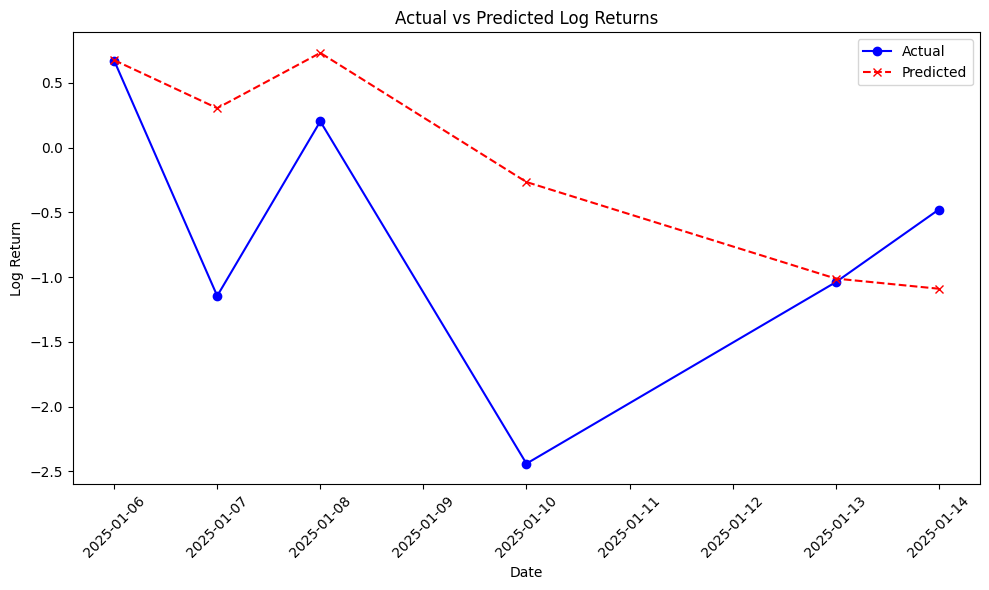

In [82]:
import matplotlib.pyplot as plt

# Plot actual vs predicted log returns
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(a.index, a.shift(1).values, label='Actual', color='blue', marker='o')

# Plot predicted values
plt.plot(p.index.values[1:], p[1:], label='Predicted', color='red', linestyle='dashed', marker='x')

# Customize plot
plt.title('Actual vs Predicted Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()

# Rotate the date labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()